In [1]:
##all coding is runing on env theano_3
# set plots inline for ipython
%matplotlib inline

# import system & ipython utils
import os
import subprocess
from IPython.display import Image
import time

# numpy and visualization libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import data preprocessing, cross validaiton

from sklearn.preprocessing import StandardScaler


from sklearn.tree import export_graphviz

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression


# performance measures
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, hamming_loss, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# personal libs
from mwutil.ml import run_training_range
from mwutil.ml import compare_classifiers

# set random seed
rand_state = np.random.RandomState(32)
# set the scoring function
# set the scoring function
scoring_function_label = 'f1_weighted'
scoring_function = f1_score

# set number of folds for cross validation
n_folds = 3

# init an empty dict to hold all models for final analysis & comparison
classifiers = {}

# define the number of 'stages' aka bins to map the UPDRS scores
n_stages = 55

# set updrs metric (total or motor)
#updrs_measure = 'total_UPDRS'

# subsampling (-1 for no subsampling)
subsample_n = -1

In [2]:
# start the wall clock
start = time.time()

#Data I/O & Preprocessing

In [13]:
# set path to dataset
train_data_path = 'D:/test_vascular_mask/test/all_features200_all.csv'
test_data_path = 'D:/test_vascular_mask/test/clean_prune_skel_all_features_100.csv'

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

df_train.dropna(inplace=True)
df_train.reset_index(drop=True,inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index(drop=True,inplace=True)

df_train = shuffle(df_train)
df_test = shuffle(df_test)

df_train.columns=['ID','NE','small_NE','big_NE','NJ', 'LE', 'LJ', 'NE/NJ', 
            'LE/LJ', 'NJ/(LJ+LE)','LJ/(LJ+LE)','NE/(LJ+LE)', 'mean_Area', 'median_Area', 'mean_Perimeter', 
            'median_Perimeter', 'mean_Eccentricity', 'median_Eccentricity','density','case','class']
df_test.columns=['ID','NE','small_NE','big_NE', 'NJ', 'LE', 'LJ', 'NE/NJ', 
            'LE/LJ', 'NJ/(LJ+LE)','LJ/(LJ+LE)','NE/(LJ+LE)', 'mean_Area', 'median_Area', 'mean_Perimeter', 
            'median_Perimeter', 'mean_Eccentricity', 'median_Eccentricity','density','class']

# split X (features), y (PD stage label) from the dataframe
features = ['NE', 'small_NE','big_NE','NJ', 'LE', 'LJ', 'NE/NJ', 
            'LE/LJ', 'NJ/(LJ+LE)','LJ/(LJ+LE)','NE/(LJ+LE)','mean_Area', 'median_Area', 'mean_Perimeter', 
            'median_Perimeter', 'mean_Eccentricity', 'median_Eccentricity','density']

X_train = df_train[features]
X_test = df_test[features]

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

y_train = df_train['class']
y_test = df_test['class']

df=df_test
X=X_test

In [17]:
# set path to dataset
train_data_path = 'D:/test_vascular_mask/test/all_features200_filted1.csv'
test_data_path = 'D:/test_vascular_mask/test/clean_prune_skel_all_features_100_filterd.csv'

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

df_train.dropna(inplace=True)
df_train.reset_index(drop=True,inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index(drop=True,inplace=True)

df_train = shuffle(df_train)
df_test = shuffle(df_test)

df_train.columns=['ID','NE','big_NE','NJ', 'LE', 'LJ', 'NE/NJ', 
            'NJ/(LJ+LE)', 'mean_Area', 'median_Area', 
            'median_Perimeter', 'mean_Eccentricity', 'median_Eccentricity','density','case','class']
df_test.columns=['ID','NE','big_NE', 'NJ', 'LE', 'LJ', 'NE/NJ', 
           'NJ/(LJ+LE)', 'mean_Area', 'median_Area',
            'median_Perimeter', 'mean_Eccentricity', 'median_Eccentricity','density','class']

# split X (features), y (PD stage label) from the dataframe
features = ['NE', 'big_NE','NJ', 'LE', 'LJ', 'NE/NJ', 
            'NJ/(LJ+LE)', 'mean_Area', 'median_Area', 
            'median_Perimeter', 'mean_Eccentricity', 'median_Eccentricity','density']

X_train = df_train[features]
X_test = df_test[features]

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

y_train = df_train['class']
y_test = df_test['class']

df=df_test
X=X_test

In [9]:
print(len(y_train))

188


In [10]:
print(len(y_test))

10


In [4]:
# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

classifiers={'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=181,
          random_state=rand_state),
 'DecisionTree': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False,
             random_state=rand_state,
             splitter='best'),
 'Gradient Boosting Trees': GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
               max_depth=3, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=299,
               presort='auto',
               random_state=rand_state,
               subsample=1.0, verbose=0, warm_start=False),
 'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=35, p=2,
            weights='uniform'),
 'Logistic Regression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=6, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=rand_state,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=219, n_jobs=1,
             oob_score=False,
             random_state=rand_state, verbose=0,
             warm_start=False),
 'svm_rbf': SVC(C=451, cache_size=200, class_weight='balanced', coef0=0.0,
   decision_function_shape="ovo", degree=3, gamma=0.01, kernel='rbf',
   max_iter=-1, probability=False,
   random_state=rand_state, shrinking=True,
   tol=0.001, verbose=False),
 'svm_sigmoid': SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
   decision_function_shape="ovo", degree=3, gamma=0.001, kernel='sigmoid',
   max_iter=-1, probability=False,
   random_state=rand_state, shrinking=True,
   tol=0.001, verbose=False)}


In [5]:
#when input is slices of one group
def predict_patient_slices(slices):
    y=model.predict(slices)
    p1=sum(y)/len(y)
    p=[1-p1,p1]
    label=np.argmax(p)
    return label

#when input are all group of slices
def predict_patient(dict_group):
    patient_label = []
    for keys,values in dict_group.items():
        y=values['predict_label']
        p1 = sum(y)/len(y)
        p = [1-p1,p1]
        label_predict = np.argmax(p)
        label_true = np.array(values['true_label'])[0:1]
        patient_label.append([int(keys),label_predict,label_true])
        t = pd.DataFrame(patient_label)
        t.columns = ['patient_id','label_predict','label_true']
    return t

#find bad data of all group of slices based on threshold
def get_bad_data(dict_group,theta):
    res=[]
    for key,value in dict_group.items():
        y=value['predict_label']
        right=(y==value['true_label'])
        p=sum(right)/len(right)
        if p<theta:
            res.append(key)
    return res

## Confusion Matricies
def confusion_matrix_patient(dict_group,patient_label_true):
    patient_label_predict = []
    for keys,values in dict_group.items():
        y=values['predict_label']
        p1 = sum(y)/len(y)
        p = [1-p1,p1]
        label_predict = np.argmax(p)
        patient_label_predict.append(label_predict)
        pd.DataFrame(patient_label_predict)
    cm = confusion_matrix(patient_label_true, patient_label_predict)
    cm_nor = np.empty(shape=[2, 2])
    cm_nor[0][0]=cm[0][0]/(cm[0][0]+cm[1][0])
    cm_nor[0][1]=cm[1][0]/(cm[0][0]+cm[1][0])
    cm_nor[1][0]=cm[1][0]/(cm[0][1]+cm[1][1])
    cm_nor[1][1]=cm[1][1]/(cm[0][1]+cm[1][1])
    return cm_nor



D:\anaconda3\lib\site-packages\sklearn\tree\_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:309: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


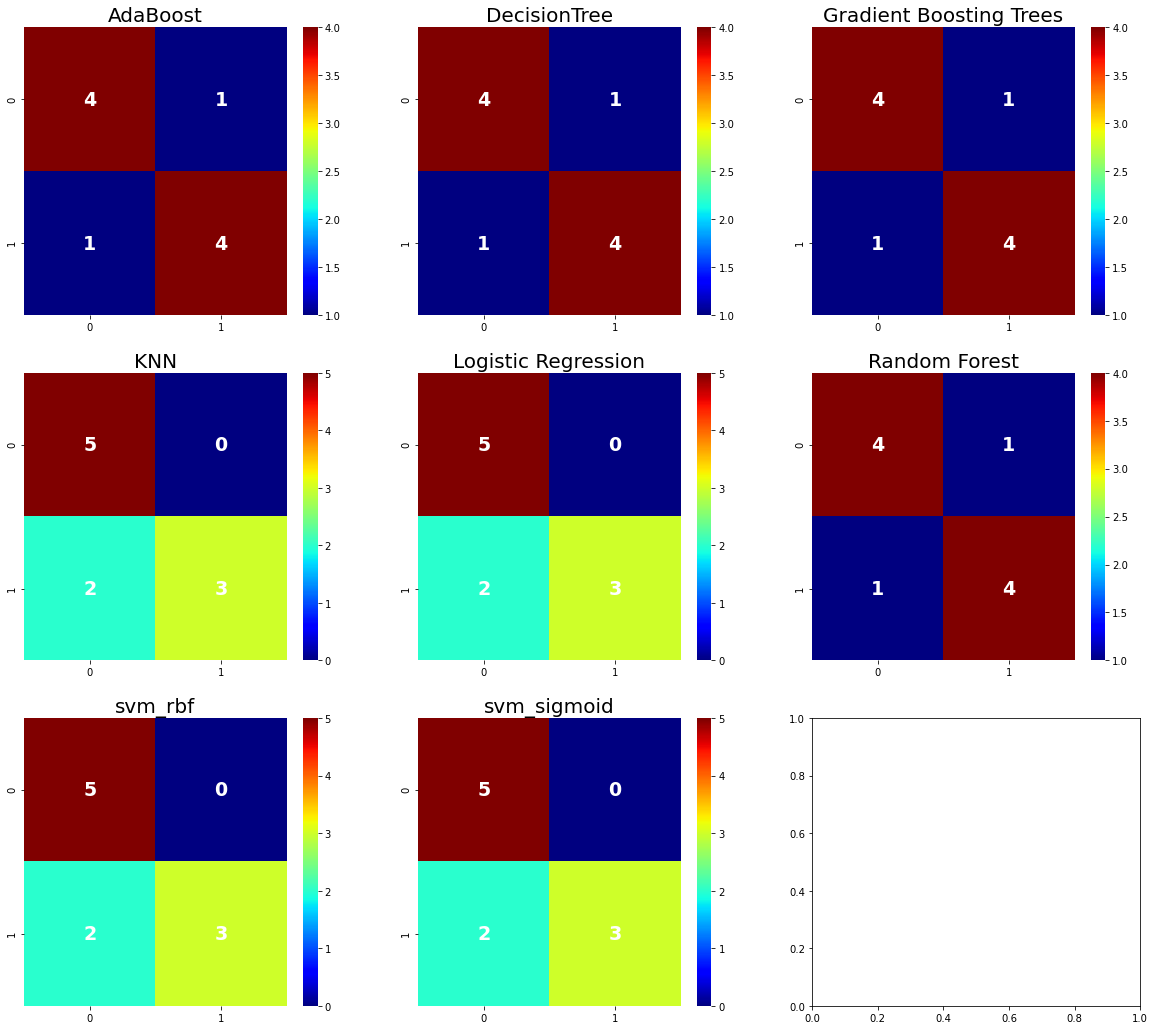

In [18]:
from sklearn.metrics import confusion_matrix
fig, axs = plt.subplots(3,3)
fig.set_size_inches(20,18)
for i, (label, clf) in enumerate(zip(classifiers.keys(), classifiers.values())):
    clf.fit(X_train, y_train.astype('int32'))
    M = confusion_matrix(y_test, clf.predict(X_test)) 
    M_nor=np.empty(shape=[2,2])
    M_nor[0][0]=M[0][0]/(M[0][0]+M[1][0])
    M_nor[0][1]=M[1][0]/(M[0][0]+M[1][0])
    M_nor[1][0]=M[0][1]/(M[0][1]+M[1][1])
    M_nor[1][1]=M[1][1]/(M[0][1]+M[1][1])
    sns.heatmap(M, ax=axs.flat[i], cmap="jet", annot=True, annot_kws={'size':19,'weight':'bold', 'color':'white'})
    axs.flat[i].set_title(label,fontsize=20)

In [7]:
def get_bad_data(X_train, y_train, X_test, y_test,all_dataframe,clf):
    res=[]
    M = np.empty(shape=[2, 2])
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    index = np.arange(0,len(y_test))
    bad_index=index[y_test != y_pred]
    for i in bad_index:
            bad=all_dataframe["ID"][i]
            res.append(bad)
    return bad_index

In [8]:
def get_bad_data(all_dataframe,clf)    
    res=[]
    M = np.empty(shape=[2, 2])
    X=all_dataframe[features]
    y=all_dataframe['true_label']:

    clf.fit(X,y)
    y_pred=clf.predict(X)
    index = np.arange(0,len(y))
    bad_index=index[y != y_pred]
    for i in bad_index:
            bad=str(all_dataframe["true_label"][i])+"_"+str(all_dataframe["case"][i])+"_"+str(all_dataframe["ID"][i])
            res.append(bad)
    return res

SyntaxError: invalid syntax (<ipython-input-8-5762e2695953>, line 1)

In [ ]:
RandomForest=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=219, n_jobs=1,
             oob_score=False,
             random_state=rand_state, verbose=0,
             warm_start=False)

In [ ]:
get_bad_data(X_train, y_train, X_test, y_test,all_dataframe,RandomForest)

In [ ]:
confusion_matrix(y_test, RandomForest.predict(X_test)) 

In [9]:
##plot Confusion Matricies by MajorityVote for classifiers
from sklearn.metrics import confusion_matrix

def training_MajorityVote_classifiers(X_train,X_test,y_train,y_test, classifiers):    
    res=[]
#    M = np.empty(shape=[2, 2])
#    X=all_dataframe[features]
#    y=all_dataframe['true_label']
    for clf in classifiers.values():
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        res.append(y_pred)
    
    y_pred_last=[]
    for j in range(len(y_test)):
        if sum(pd.DataFrame(res)[j]==y_test[j])>len(classifiers)/2:
            y_pred_last.append(y_test[j])
        else:
            y_pred_last.append(1-y_test[j])

    CM=confusion_matrix(y_test, y_pred_last)

    return res,CM,y_pred_last


In [19]:
res,M,y_pred_last=training_MajorityVote_classifiers(X_train,X_test,y_train,y_test, classifiers)

D:\anaconda3\lib\site-packages\sklearn\tree\_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:309: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [24]:
confusion_matrix(y_test, y_pred_last)

array([[5, 0],
       [2, 3]], dtype=int64)

In [25]:
M

array([[5, 0],
       [2, 3]], dtype=int64)

In [40]:
#正确的M_nor
M_nor = np.empty(shape=[2, 2])
M=confusion_matrix(y_test, y_pred_last)
M_nor[0][0]=M[0][0]/(M[0][0]+M[0][1])
M_nor[0][1]=M[0][1]/(M[0][0]+M[0][1])
M_nor[1][0]=M[1][0]/(M[1][0]+M[1][1])
M_nor[1][1]=M[1][1]/(M[1][0]+M[1][1])
M_nor

array([[1. , 0. ],
       [0.4, 0.6]])

<AxesSubplot:>

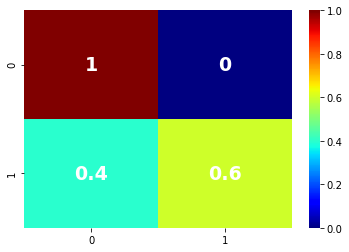

In [39]:
fig, axs = plt.subplots(1,1)
sns.heatmap(M_nor, cmap="jet", annot=True, annot_kws={'size':19,'weight':'bold', 'color':'white'})